In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from mango.tuner import Tuner

In [5]:
param_space = dict(
    growth=["linear", "logistic", "flat"],
    n_changepoints=range(0, 55, 5),
    changepoint_range=np.linspace(0.5, 1),
    yearly_seasonality=[True, False],
    weekly_seasonality=[True, False],
    daily_seasonality=[True, False],
    seasonality_mode=["additive", "multiplicative"],
    seasonality_prior_scale=np.linspace(5.0, 20.0),
    changepoint_prior_scale=np.linspace(0.0, 0.1),
    interval_width=np.linspace(0.2, 1),
    uncertainty_samples=[500, 1000, 1500, 2000],
)

In [6]:
df = pd.read_csv('CASTHPI.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'observation_date': 'ds', 'CASTHPI': 'y'}, inplace=True)

test size: 40


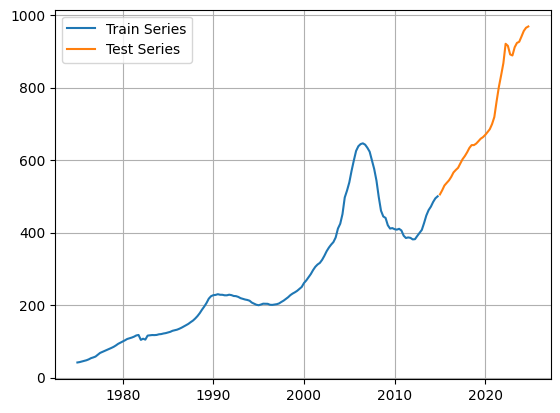

In [7]:
test_size = int(0.2 * len(df))
train_df = df.head(len(df) - test_size)
test_df = df.tail(test_size)
print("test size:", test_size)
plt.plot(train_df['ds'], train_df['y'], label = "Train Series")
plt.plot(test_df['ds'], test_df['y'], label = "Test Series")
plt.legend()
plt.grid()

In [8]:
def objective_function(args_list):
    global train_df, test_df
    params_evaluated = []
    results = []
    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(train_df)
            future = model.make_future_dataframe(periods=test_size, freq="M")
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(test_size)
            error = mean_absolute_percentage_error(
                test_df["y"], predictions_tuned["yhat"]
            )
            params_evaluated.append(params)
            results.append(error)
        except:
            # print(f"Exception raised for {params}")
            # pass
            params_evaluated.append(params)
            results.append(25.0)  # Giving high loss for exceptions regions of spaces

    return params_evaluated, results

In [9]:
tuner = Tuner(param_space, objective_function)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

22:37:41 - cmdstanpy - INFO - Chain [1] start processing
22:37:41 - cmdstanpy - INFO - Chain [1] done processing
22:37:41 - cmdstanpy - INFO - Chain [1] start processing
22:37:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]22:38:06 - cmdstanpy - INFO - Chain [1] start processing
22:38:06 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.22318807840455798:   5%|▌         | 1/20 [00:23<07:30, 23.72s/it]22:38:30 - cmdstanpy - INFO - Chain [1] start processing
22:38:30 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.22215251025468774:  10%|█         | 2/20 [00:45<06:47, 22.65s/it]22:38:51 - cmdstanpy - INFO - Chain [1] start processing
22:38:51 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.22215251025468774:  15%|█▌        | 3/20 [01:07<06:20, 22.39s/it]22:39:13 - cmdstanpy - INFO - Chain [1] start processing
22:39:13 - cmdstanpy - INFO - Chain [1] done processing
Best score: 0.22215251025468774:  20%|██       

best parameters: {'changepoint_prior_scale': np.float64(0.05510204081632654), 'changepoint_range': np.float64(0.7551020408163265), 'daily_seasonality': False, 'growth': 'linear', 'interval_width': np.float64(0.2163265306122449), 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': np.float64(7.755102040816327), 'uncertainty_samples': 2000, 'weekly_seasonality': False, 'yearly_seasonality': True}
best loss: 0.21152505576774588


22:45:43 - cmdstanpy - INFO - Chain [1] start processing
22:45:43 - cmdstanpy - INFO - Chain [1] done processing


loss value: 0.1714643027764508


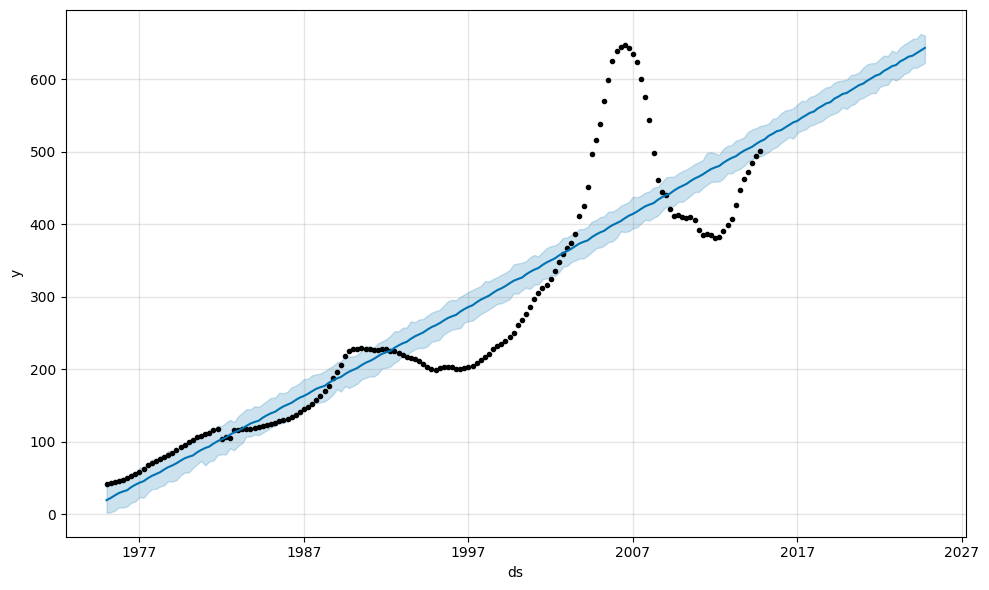

In [10]:
model = Prophet(**results["best_params"])
model.fit(train_df)
future = model.make_future_dataframe(periods=40, freq='Q')
forecast = model.predict(future)
forecast.tail()
error = mean_absolute_percentage_error(test_df['y'], forecast.tail(test_size)['yhat'])   
print('loss value:', error)
model.plot(forecast)
plt.show()